# Problem Statement
In this assignment students have to make ARIMA model over shampoo sales data and check the MSE between predicted and actual value.

# Import Libraries

In [1]:
from pandas import read_csv
from pandas import datetime
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
def parser(x):
    m = x.split('-')[0]
    if len(m) < 2:
        return datetime.strptime('190'+x, '%Y-%b')
    else:
        return datetime.strptime('19'+x, '%Y-%b')

In [36]:
df = pd.read_csv('Shampoo_Sales.csv',header=None)

In [37]:
df.head()

,0,1
0,1-Jan,266.0
1,2-Jan,145.9
2,3-Jan,183.1
3,4-Jan,119.3
4,5-Jan,180.3


In [38]:
df.describe()

,1
count,36.000000
mean,312.600000
std,148.937164
min,119.300000
25%,192.450000
50%,280.150000
75%,411.100000
max,682.000000


In [39]:
df.isnull().count()

0    36
1    36
dtype: int64

In [40]:
df[0] = df[0].astype(str)

In [41]:
df.dtypes

0     object
1    float64
dtype: object

In [42]:
df.head()

,0,1
0,1-Jan,266.0
1,2-Jan,145.9
2,3-Jan,183.1
3,4-Jan,119.3
4,5-Jan,180.3


In [43]:
df.isnull().count()

0    36
1    36
dtype: int64

# Preparing the Data

In [44]:
df.dropna(inplace = True)

In [45]:
df[0] = df[0].apply(lambda x : parser(x))

In [46]:
df = df.rename(columns={0:'Month',1:'Shampoo_Sales'})

In [47]:
df.head()

,Month,Shampoo_Sales
0,1901-01-01,266.0
1,1902-01-01,145.9
2,1903-01-01,183.1
3,1904-01-01,119.3
4,1905-01-01,180.3


In [48]:
df['Month'] = pd.to_datetime(df['Month'])

In [49]:
df.set_index('Month',inplace=True)

# Autoregressive Integrated Moving Averages

The general process for ARIMA models is the following:

* Visualize the Time Series Data
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the ARIMA Model

Use the model to make predictions


#### Visualize Data

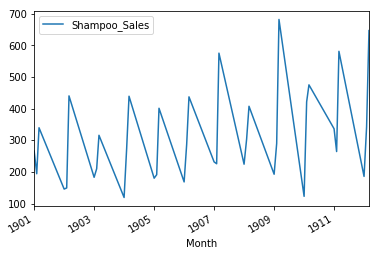

In [21]:
df.plot()

We can see that the Shampoo Sales dataset has a clear trend.

This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1

#### Autocorrelation plot of the time series. This is also built-in to Pandas. 

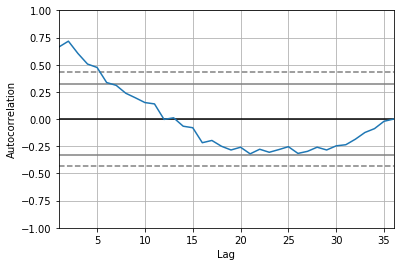

In [22]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df)

Running the example, we can see that there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags.

A good starting point for the AR parameter of the model may be 5.

In [23]:
timeseries = df['Shampoo_Sales']

In [24]:
timeseries.index

DatetimeIndex(['1901-01-01', '1902-01-01', '1903-01-01', '1904-01-01',
               '1905-01-01', '1906-01-01', '1907-01-01', '1908-01-01',
               '1909-01-01', '1910-01-01', '1911-01-01', '1912-01-01',
               '1901-02-01', '1902-02-01', '1903-02-01', '1904-02-01',
               '1905-02-01', '1906-02-01', '1907-02-01', '1908-02-01',
               '1909-02-01', '1910-02-01', '1911-02-01', '1912-02-01',
               '1901-03-01', '1902-03-01', '1903-03-01', '1904-03-01',
               '1905-03-01', '1906-03-01', '1907-03-01', '1908-03-01',
               '1909-03-01', '1910-03-01', '1911-03-01', '1912-03-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

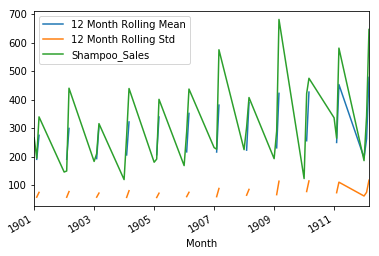

In [25]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()

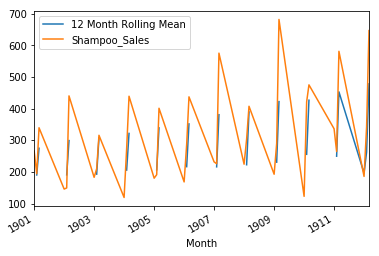

In [89]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.plot()
plt.legend()

## Testing for Stationarity

We can use the Augmented [Dickey-Fuller](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) [unit root test](https://en.wikipedia.org/wiki/Unit_root_test).

In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Basically, we are trying to whether to accept the Null Hypothesis **H0** (that the time series has a unit root, indicating it is non-stationary) or reject **H0** and go with the Alternative Hypothesis (that the time series has no unit root and is stationary).

We end up deciding this based on the p-value return.

* A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.

* A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.

Let's run the Augmented Dickey-Fuller test on our data:

In [26]:
df.head()

,Shampoo_Sales
Month,
1901-01-01,266.0
1902-01-01,145.9
1903-01-01,183.1
1904-01-01,119.3
1905-01-01,180.3


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 1901-01-01 to 1912-03-01
Data columns (total 1 columns):
Shampoo_Sales    36 non-null float64
dtypes: float64(1)
memory usage: 576.0 bytes


In [28]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Shampoo_Sales'])
result

(3.060142083641181,
 1.0,
 10,
 25,
 {'1%': -3.7238633119999998, '10%': -2.6328004, '5%': -2.98648896},
 278.9972644263031)

In [29]:
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : 3.060142083641181
p-value : 1.0
#Lags Used : 10
Number of Observations Used : 25
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [30]:
# Store in a function for later use!
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [32]:
adf_check(df['Shampoo_Sales'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : 3.060142083641181
p-value : 1.0
#Lags Used : 10
Number of Observations Used : 25
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


#### Important Note!
We have now realized that our data is seasonal (it is also pretty obvious from the plot itself). This means we need to use Seasonal ARIMA on our model. If our data was not seasonal, it means we could use just ARIMA on it. We will take this into account when differencing our data! Typically financial stock data won't be seasonal, but that is kind of the point of this section, to show you common methods, that won't work well on stock finance data!

# Differencing
The first difference of a time series is the series of changes from one period to the next. We can do this easily with pandas. You can continue to take the second difference, third difference, and so on until your data is stationary.

In [50]:
df['Shampoo_Sales_first_difference'] = df['Shampoo_Sales'] - df['Shampoo_Sales'].shift(1)

In [51]:
df.head()

,Shampoo_Sales,Shampoo_Sales_first_difference
Month,,
1901-01-01,266.0,NaN
1902-01-01,145.9,-120.1
1903-01-01,183.1,37.2
1904-01-01,119.3,-63.8
1905-01-01,180.3,61.0


In [53]:
adf_check(df['Shampoo_Sales_first_difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -7.249074055553854
p-value : 1.7998574141687034e-10
#Lags Used : 1
Number of Observations Used : 33
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


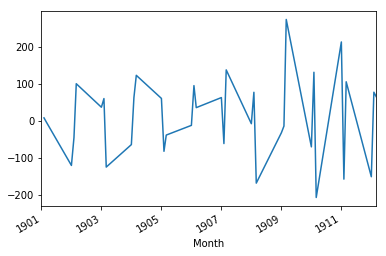

In [54]:
df['Shampoo_Sales_first_difference'].plot()

#### Seasonal Difference 

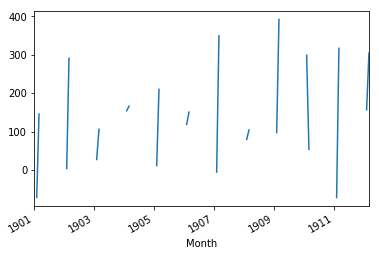

In [55]:
df['Seasonal Difference'] = df['Shampoo_Sales'] - df['Shampoo_Sales'].shift(12)
df['Seasonal Difference'].plot()

In [56]:
# Seasonal Difference by itself was not enough!
adf_check(df['Seasonal Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -0.04561553414248672
p-value : 0.9545931714075301
#Lags Used : 6
Number of Observations Used : 17
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


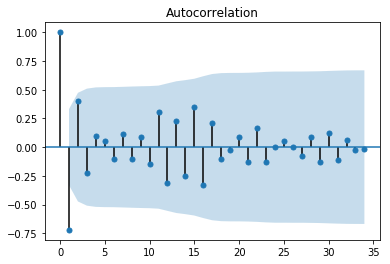

In [57]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig_first = plot_acf(df["Shampoo_Sales_first_difference"].dropna())

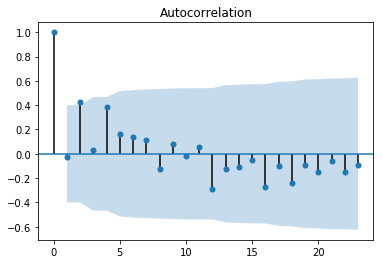

In [58]:
df["Seasonal First Difference"] =  df['Shampoo_Sales'] - df['Shampoo_Sales'].shift(12)
fig_seasonal_first = plot_acf(df["Seasonal First Difference"].dropna())

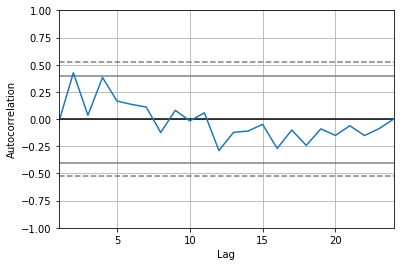

In [59]:
autocorrelation_plot(df['Seasonal First Difference'].dropna())

C:\Users\INTEL\Anaconda3\envs\tfdeeplearning\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


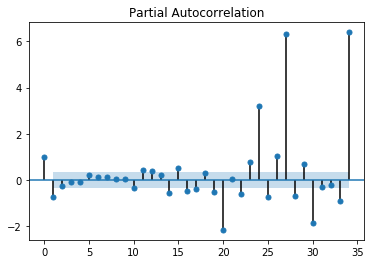

In [60]:
result = plot_pacf(df["Shampoo_Sales_first_difference"].dropna())

In [26]:
# For non-seasonal data
from statsmodels.tsa.arima_model import ARIMA

### p,d,q parameters

* p: The number of lag observations included in the model.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

p: the number before the first inverted bar in the ACF (we begin counting from 0)
d: the number of times we differenced our time series to achieve stationarity
q: the number before the first inverted bar in our PACF (we begin counting from 0)

In [186]:
df.head()

,Shampoo_Sales,Milk First Difference,Seasonal First Difference,forecast
Month,,,,
1901-01-01,266.0,NaN,NaN,NaN
1902-01-01,145.9,-120.1,NaN,266.0
1903-01-01,183.1,37.2,NaN,266.0
1904-01-01,119.3,-63.8,NaN,266.0
1905-01-01,180.3,61.0,NaN,266.0


# ARIMA with Python
The statsmodels library provides the capability to fit an ARIMA model.

An ARIMA model can be created using the statsmodels library as follows:

Define the model by calling ARIMA() and passing in the p, d, and q parameters.
The model is prepared on the training data by calling the fit() function.
Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.
Let’s start off with something simple. We will fit an ARIMA model to the entire Shampoo Sales dataset and review the residual errors.

First, we fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.

When fitting the model, a lot of debug information is provided about the fit of the linear regression model. We can turn this off by setting the disp argument to 0.

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                       css-mle   S.D. of innovations             64.241
Date:                Sun, 30 Sep 2018   AIC                            406.340
Time:                        22:26:09   BIC                            417.227
Sample:                             1   HQIC                           410.098
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0649      3.652      3.304      0.003       4.908      19.222
ar.L1.D.y     -1.1082      0.183     -6.063      0.000      -1.466      -0.750
ar.L2.D.y     -0.6203      0.282     -2.203      0.0

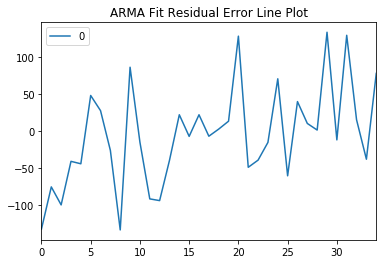

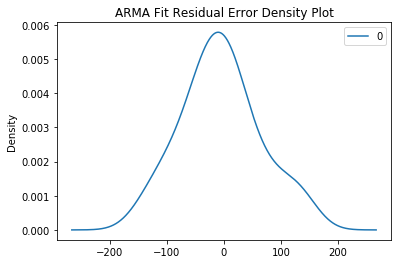

                0
count   35.000000
mean    -5.495254
std     68.132879
min   -133.296630
25%    -42.477923
50%     -7.186696
75%     24.748294
max    133.237951


In [62]:
# fit model
model = ARIMA(df['Shampoo_Sales'].values, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.title('ARMA Fit Residual Error Line Plot')
plt.show()
residuals.plot(kind='kde')
plt.title('ARMA Fit Residual Error Density Plot')
plt.show()
print(residuals.describe())

predicted=349.117623, expected=342.300000
predicted=306.512928, expected=339.700000
predicted=387.376405, expected=440.400000
predicted=348.154206, expected=315.900000
predicted=386.308782, expected=439.300000
predicted=356.082061, expected=401.300000
predicted=446.379487, expected=437.400000
predicted=394.737317, expected=575.500000
predicted=434.915513, expected=407.600000
predicted=507.923355, expected=682.000000
predicted=435.482830, expected=475.300000
predicted=652.743749, expected=581.300000
predicted=546.343527, expected=646.900000

-------------------------------------------------------------
Test MSE : 6958.326

-------------------------------------------------------------


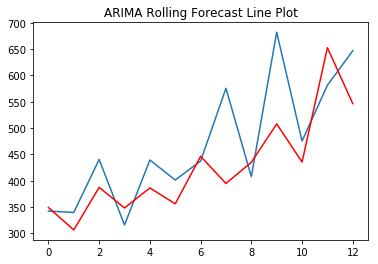

In [66]:
X = df['Shampoo_Sales'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('\n-------------------------------------------------------------')
print('Test MSE : %.3f' % error)
print('\n-------------------------------------------------------------')
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.title('ARIMA Rolling Forecast Line Plot')
plt.show()